In [1]:
from pynq import Overlay
from pynq import Clocks

ol = Overlay("esg_engine.bit")
ol.download()
print(f"current IP PL clock hz: {Clocks.fclk0_mhz}Mhz")

print(ol.ip_dict.keys())
ip = ol.sa_engine_ip_0
print(ip.register_map)
rm = ip.register_map

current IP PL clock hz: 100.0Mhz
dict_keys(['sa_engine_ip_0', 'processing_system7_0'])
RegisterMap {
  CONTROL = Register(value=0),
  N = Register(value=0),
  K = Register(value=0),
  M = Register(value=0),
  BLOCK_M = Register(value=0),
  BASE_A = Register(value=0),
  BASE_B = Register(value=0),
  BASE_C = Register(value=0),
  STRIDE_A = Register(value=0),
  STRIDE_B = Register(value=0),
  STRIDE_C = Register(value=0)
}


# HW Function

In [2]:
import numpy as np
from pynq import allocate

# ============================================
# Step 1: Prepare Function to Call FPGA
# ============================================
START_MASK     = 0b00001  # bit[0]
UPDATE_A_MASK  = 0b00010  # bit[1]

DONE_MASK      = 0b00100  # bit[16]
BUSY_MASK      = 0b01000  # bit[17]
ERR_MASK       = 0b10000  # bit[18]

def get_status(ip):
    return int(rm.CONTROL)

def ip_done(ctrl_bit):
    return bool(ctrl_bit & DONE_MASK)

def ip_is_busy(ctrl_bit):
    return bool(ctrl_bit & BUSY_MASK)

def ip_has_error(ctrl_bit):
    return bool(ctrl_bit & ERR_MASK)

def call_fpga(ip, N, K, M, BLOCK_M, A_buf, B_buf, C_buf, update_A, STRIDE_A, STRIDE_B, STRIDE_C):
    """
    Runs a 2D matrix multiplication on the FPGA accelerator:
      (N, K) x (K, M) => (N, M)

    A_buf, B_buf, C_buf are PYNQ buffers allocated with shape=(N,K), (K,M), (N,M).
    update_A: 1 to load A into BRAM (new input), 0 to reuse persistent A.
    """
    print("calling fpga, update_A =", update_A)
    
    # Flush input buffers to ensure data consistency.
    # Only flush A_buf if we intend to update A (update_A==1).
    if update_A:
        A_buf.flush()
    B_buf.flush()

    #######################################
    # Configure the accelerator registers 
    #######################################
    
    ctrl = 0
    if update_A:
        ctrl = UPDATE_A_MASK

    rm.CONTROL = ctrl
    rm.N = N
    rm.K = K
    rm.M = M
    rm.BLOCK_M = BLOCK_M
    rm.BASE_A = A_buf.physical_address
    rm.BASE_B = B_buf.physical_address
    rm.BASE_C = C_buf.physical_address
    rm.STRIDE_A = STRIDE_A
    rm.STRIDE_B = STRIDE_B
    rm.STRIDE_C = STRIDE_C

    #######################
    # Run the accelerator 
    #######################
    
    rm.CONTROL = ctrl | START_MASK
    rm.CONTROL = ctrl

    while True:
        status = get_status(ip)
        if ip_has_error(status):
            print("ip_error detected")
            break
        if ip_done(status):
            break

    C_buf.invalidate()
    print("ip_done")
#########################################
# PYNQ-Z2 has no power sensor available
#########################################

# DDR & Register Value Setting

In [3]:
# ============================================
# Step 2: Prepare Buffers
# ============================================

# Parameters for DistilBERT
N, K, M = 64, 768, 3072
BLOCK_M = 16
STRIDE_A = 768
STRIDE_B = 3072
STRIDE_C = 3072*4

# Buffer for input
A_buf = allocate(shape=(N, K), dtype=np.int8, cacheable=False)
B_buf = allocate(shape=(K, M), dtype=np.int8, cacheable=False)
# Buffer for output
C_buf = allocate(shape=(N, M), dtype=np.int32, cacheable=False)

# Initialize Input Data : Random int8
A_buf[:] = np.random.randint(-128, 127, size=(N,K), dtype=np.int8)
B_buf[:] = np.random.randint(-128, 127, size=(K,M), dtype=np.int8)

# flush caches
A_buf.flush()
B_buf.flush()

# Testbench

## HW Compute

In [4]:
import time

# ============================================
# Step 3: BENCHMARK - FPGA ACCELERATOR
# ============================================

start_data_in = time.perf_counter()
A_buf.flush()
B_buf.flush()
end_data_in = time.perf_counter()

start_fpga = time.perf_counter()
call_fpga(ip, N, K, M, BLOCK_M, A_buf, B_buf, C_buf, update_A=1, STRIDE_A=STRIDE_A, STRIDE_B=STRIDE_B, STRIDE_C=STRIDE_C)
end_fpga = time.perf_counter()

start_data_out = time.perf_counter()
C_buf.invalidate()
result_fpga = C_buf[:, :].copy()
end_data_out = time.perf_counter()

calling fpga, update_A = 1
ip_done


# SW Reference

In [5]:
import time

# ===========================
# Step 4: CPU REFERENCE (NumPy)
# ===========================

#########################################
# NumPy CPU Reference
#########################################
start_cpu_numpy = time.perf_counter()
ref_numpy = np.matmul(
    A_buf.astype(np.int32),
    B_buf.astype(np.int32)
)
end_cpu_numpy = time.perf_counter()

#########################################
# PyTorch : Not available on PYNQ-Z2
#########################################

# HW vs SW

In [6]:
# ============================
# Step 5: ACCURACY CHECK
# ============================
diff_numpy = np.abs(ref_numpy - result_fpga)
max_err_numpy = np.max(diff_numpy)

# ============================
# Step 6: PERFORMANCE METRICS
# ============================
total_ops = 2 * N * K * M

acc_latency = end_fpga - start_fpga
total_hw_time = end_data_out - start_data_in
hw_throughput = (total_ops / acc_latency) / 1e9
hw_end_to_end = (total_ops / total_hw_time) / 1e9

sw_time_numpy = end_cpu_numpy - start_cpu_numpy
sw_throughput_numpy = (total_ops / sw_time_numpy) / 1e9
speedup_latency_numpy = sw_time_numpy / acc_latency
speedup_total_numpy = sw_time_numpy / total_hw_time

print(result_fpga)
print(ref_numpy)

[[-158003 -217853   23509 ...  -62206  -57541  -23124]
 [   3553  283890  -23872 ...   -3813  195886  150151]
 [-353137 -248270   29367 ...  -51264   46015 -291436]
 ...
 [  84464  -89068 -171213 ... -326196   14386  -39213]
 [ -58745  223018  185542 ...   75877   50584 -190926]
 [  24476  -33599  239113 ... -193028  -11277 -175525]]
[[-158003 -217853   23509 ...  -62206  -57541  -23124]
 [   3553  283890  -23872 ...   -3813  195886  150151]
 [-353137 -248270   29367 ...  -51264   46015 -291436]
 ...
 [  84464  -89068 -171213 ... -326196   14386  -39213]
 [ -58745  223018  185542 ...   75877   50584 -190926]
 [  24476  -33599  239113 ... -193028  -11277 -175525]]



## **Performance Comparison: FPGA vs NumPy**

### **Matrix Multiplication Details**
- **Matrix Shape**: `[64, 768] × [768, 3072]`
- **Accuracy Check**:
  - ✅ **Max Difference (NumPy vs FPGA)**: `0`

---

### **Latency & Throughput**
| Framework  | Latency (sec) | Throughput (GFLOPs) |
|------------|--------------|----------------------|
| NumPy   | `25.784205`  | `0.01` GFLOPs |
| FPGA    | `0.142162`  | `2.12` GFLOPs |

- **Total HW Execution Time**: `0.152115` sec  
- **Overall FPGA Throughput**: `1.99` GFLOPs  

---

### **Speedup Comparison**
| Comparison  | Speedup (Latency) | Speedup (Total) |
|-------------|------------------|-----------------|
| FPGA vs NumPy   | `181.37×` | `169.50×` |

✅ **Test Completed!**


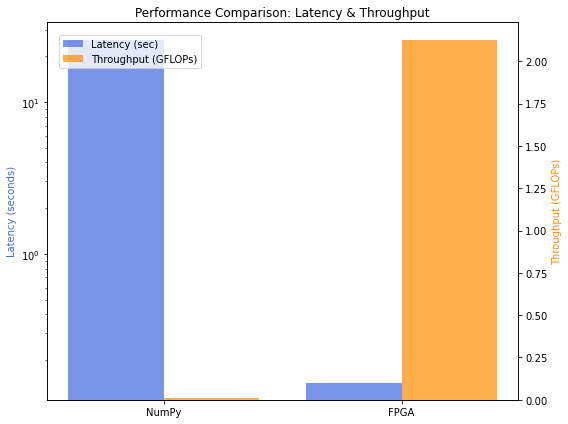

In [7]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# Generate Markdown dynamically
md_text = f"""
## **Performance Comparison: FPGA vs NumPy**

### **Matrix Multiplication Details**
- **Matrix Shape**: `[{N}, {K}] × [{K}, {M}]`
- **Accuracy Check**:
  - {"✅" if max_err_numpy == 0 else "❌"} **Max Difference (NumPy vs FPGA)**: `{max_err_numpy}`

---

### **Latency & Throughput**
| Framework  | Latency (sec) | Throughput (GFLOPs) |
|------------|--------------|----------------------|
| NumPy   | `{sw_time_numpy:.6f}`  | `{sw_throughput_numpy:.2f}` GFLOPs |
| FPGA    | `{acc_latency:.6f}`  | `{hw_throughput:.2f}` GFLOPs |

- **Total HW Execution Time**: `{total_hw_time:.6f}` sec  
- **Overall FPGA Throughput**: `{hw_end_to_end:.2f}` GFLOPs  

---

### **Speedup Comparison**
| Comparison  | Speedup (Latency) | Speedup (Total) |
|-------------|------------------|-----------------|
| FPGA vs NumPy   | `{speedup_latency_numpy:.2f}×` | `{speedup_total_numpy:.2f}×` |

✅ **Test Completed!**
"""

# Display the Markdown
display(Markdown(md_text))

# ================================
# Visualization
# ================================

# Data for plotting
frameworks = ["NumPy", "FPGA"]
latencies = [sw_time_numpy, acc_latency]  # Lower is better
throughputs = [sw_throughput_numpy, hw_throughput]  # Higher is better

x = np.arange(len(frameworks))

# Create figure
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

# Bar width
bar_width = 0.4

# Plot latency & throughput (first subplot)
ax1.bar(x - bar_width / 2, latencies, width=bar_width, label="Latency (sec)", color='royalblue', alpha=0.7)
ax1.set_ylabel("Latency (seconds)", color='royalblue')
ax1.set_yscale("log")

ax3 = ax1.twinx()
ax3.bar(x + bar_width / 2, throughputs, width=bar_width, label="Throughput (GFLOPs)", color='darkorange', alpha=0.7)
ax3.set_ylabel("Throughput (GFLOPs)", color='darkorange')

ax1.set_xticks(x)
ax1.set_xticklabels(frameworks)
ax1.set_title("Performance Comparison: Latency & Throughput")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.92))

# Adjust layout and show plot
plt.tight_layout()
plt.show()